In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from statsmodels.miscmodels.ordinal_model import OrderedModel


In [2]:
%reload_ext autoreload
%autoreload 2

path = '../data/'  # Change this to your path


FIELDS = [
    "coa_gr1a",
    "col_gr1a",
    "fnl_gr1a",
    "lti_gr1a",
    "lnoa_gr1a",
    "nfna_gr1a",
    "cowc_gr1a",
    "nncoa_gr1a",
    "noa_gr1a",
    "ncoa_gr1a",
    "ncol_gr1a",
    "ppeinv_gr1a",
    "sti_gr1a",
    "dolvol_var_126d",
    "turnover_var_126d",
    "debt_gr3",
    "eqnpo_12m",
    "coskew_21d",
    "debt_me",
    "div12m_me",
    "dolvol_126d",
    "betadown_252d",
    "ni_ar1",
    "ni_ivol",
    "earnings_variability",
    "niq_su",
    "ni_me",
    "bev_mev",
    "ebitda_mev",
    "eq_dur",
    "age",
    "f_score",
    "gp_at",
    "gp_atl1",
    "rmax5_21d",
    "rmax5_rvol_21d",
    "emp_gr1",
    "iskew_capm_21d",
    "iskew_ff3_21d",
    "iskew_hxz4_21d",
    "ivol_capm_252d",
    "ivol_capm_21d",
    "ivol_ff3_21d",
    "ivol_hxz4_21d",
    "ival_me",
    "inv_gr1a",
    "inv_gr1",
    "capx_gr1",
    "at_gr1",
    "sale_emp_gr1",
    "aliq_at",
    "aliq_mat",
    "ret_60_12",
    "corr_1260d",
    "rmax1_21d",
    "mispricing_mgmt",
    "mispricing_perf",
    "dbnetis_at",
    "netdebt_me",
    "eqnetis_at",
    "netis_at",
    "noa_at",
    "eqnpo_me",
    "chcsho_12m",
    "ni_inc8q",
    "o_score",
    "oaccruals_at",
    "ocf_at",
    "ocf_me",
    "opex_at",
    "op_at",
    "ope_be",
    "op_atl1",
    "ope_bel1",
    "ret_12_7",
    "ret_3_1",
    "ret_9_1",
    "eqpo_me",
    "oaccruals_ni",
    "taccruals_ni",
    "dgp_dsale",
    "dsale_drec",
    "dsale_dinv",
    "dsale_dsga",
    "ret_6_1",
    "ret_12_1",
    "prc",
    "zero_trades_252d",
    "zero_trades_21d",
    "zero_trades_126d",
    "ebit_sale",
    "qmj",
    "qmj_growth",
    "qmj_prof",
    "qmj_safety"
]


FIELDS_QMJ = ['qmj', 'qmj_prof', 'qmj_growth', 'qmj_safety']


# Load data
return_series = pd.read_parquet(f'{path}usa_returns.parquet')
# features = pd.read_parquet(f'{path}usa_features.parquet')
features = pd.read_parquet(f'{path}usa_features_old.parquet', columns = FIELDS)
# features = pd.read_parquet(f'{path}usa_features.parquet')


/tmp/ipykernel_3428/3621161094.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


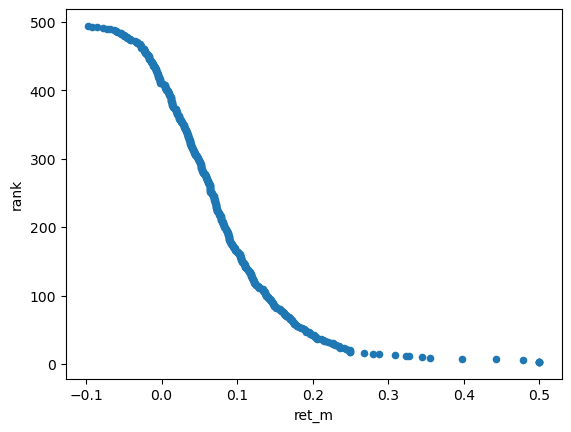

In [3]:
return_series_monthly = np.exp(np.log(1 + return_series).resample('M').sum()) - 1

## Winsorize
return_series_monthly[return_series_monthly > 0.5] = 0.5
return_series_monthly[return_series_monthly < -0.5] = -0.5
##  Compute the ranks for each row of the monthly return series DataFrame
labels = return_series_monthly.rank(axis = 1).astype(int)
## We multiply the returns by -1 to ensure that the rank is in ascending order (i.e. the highest return is ranked 1)
labels = (return_series_monthly * (-1)).rank(axis = 1).astype(int)

# Check the ranks
tmp = pd.concat([return_series_monthly.loc['2023-12-31'], labels.loc['2023-12-31']], axis = 1)
tmp.columns = ['ret_m', 'rank']
tmp.plot(kind = 'scatter', x = 'ret_m', y = 'rank')

## Alternatively, further group ranks (row-wise) into deciles
labels = labels.apply(lambda x: pd.qcut(x, 10, labels = False), axis = 1)
labels_bin = labels.apply(lambda x: pd.qcut(x, 2, labels = False), axis = 1)

## Lag the labels by -1 month (to predict next month's returns rank)
labels = labels.shift(-1).dropna()

## Unstack the dataframe
y = labels.unstack().reorder_levels([1, 0])
y.columns = ['label']

# Prepare the features
X = features[ features.index.get_level_values(0).isin(labels.index) ]
X.fillna(0, inplace=True)

# Merge
merged_df = X.copy()
merged_df.insert(0, 'label', y)
merged_df = merged_df[ merged_df.index.get_level_values(0).isin( y.index.get_level_values(0).intersection(X.index.get_level_values(0)) ) ]
merged_df = merged_df[ merged_df.index.get_level_values(1).isin( y.index.get_level_values(1).intersection(X.index.get_level_values(1)) ) ]
merged_df.reset_index(inplace = True)
# merged_df.tail(5)
# merged_df['datadate'].unique().max()

In [4]:
split_date =  '2023-12-31'
df_train = merged_df[merged_df['datadate'] < split_date].reset_index(drop = True)
df_test = merged_df[merged_df['datadate'] == split_date].reset_index(drop = True)

X_train = df_train.drop(['datadate', 'gvkey', 'label'], axis=1)
y_train = df_train['label']
grouped_train = df_train.groupby('datadate').size().to_numpy()

X_test = df_test.drop(['datadate', 'gvkey', 'label'], axis=1)
y_test = df_test['label']
grouped_test = df_test.groupby('datadate').size().to_numpy()


# Ordinal Regression


The parameterization corresponds to the proportional odds model in the logistic case. The model assumes that the endogenous variable is ordered but that the labels have no numeric interpretation besides the ordering.

The model is based on a latent linear variable, where we observe only a discretization.

$$y_{latent} = x^T \beta + \epsilon$$

The observed variable is defined by the interval

$y = 0$ if $y_{latent}  <= cut_1$

$y = 1$ if $cut_1 <= y_{latent}  <= cut_2$
.
.
.
$y = N$ if $cut_{N} <= y_{latent}  <= cut_2$

The probability of observing y=k conditional on the explanatory variables X is given by

prob(y = k | x) = Prob(cut_k < y_latent <= cut_k+1)
= Prob(cut_k - x beta < u <= cut_k+1 - x beta = F(cut_k+1 - x beta) - F(cut_k - x beta)

Where F is the cumulative distribution of u which is either the normal or the logistic distribution, but can be set to any other continuous distribution. We use standardized distributions to avoid identifiability problems.

# Probit ordinal regression

In [5]:
mod_prob = OrderedModel(endog = y_train.astype('category'),
                        exos = X_train.values,
                        distr='probit')

res_prob = mod_prob.fit(method='bfgs')

/home/akaboshi/anaconda3/lib/python3.11/site-packages/statsmodels/miscmodels/ordinal_model.py:206: Warning: the endog has ordered == False, risk of capturing a wrong order for the categories. ordered == True preferred.
  warnings.warn("the endog has ordered == False, "
/home/akaboshi/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1359: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 2.302535
         Iterations: 0
         Function evaluations: 57
         Gradient evaluations: 45


/home/akaboshi/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
predicted = res_prob.model.predict(res_prob.params, exog=X_test)

pred_choice = predicted.argmax(1)

In [7]:
pred_choice

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

In [9]:
print('Fraction of correct choice predictions')
print(y_test == pred_choice)

Fraction of correct choice predictions
0      False
1      False
2      False
3      False
4      False
       ...  
438    False
439    False
440     True
441    False
442    False
Name: label, Length: 443, dtype: bool


# Logit ordinal regression

In [10]:
mod_log = OrderedModel(y_train.astype('category'),
                        X_train.values,
                        distr='logit')

res_log = mod_prob.fit(method='bfgs', disp=False)
res_log.summary()

/home/akaboshi/anaconda3/lib/python3.11/site-packages/statsmodels/miscmodels/ordinal_model.py:206: Warning: the endog has ordered == False, risk of capturing a wrong order for the categories. ordered == True preferred.
  warnings.warn("the endog has ordered == False, "
/home/akaboshi/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  label   Log-Likelihood:            -2.3698e+05
Model:                   OrderedModel   AIC:                         4.742e+05
Method:            Maximum Likelihood   BIC:                         4.752e+05
Date:                Sun, 04 Aug 2024                                         
Time:                        11:57:59                                         
No. Observations:              102920                                         
Df Residuals:                  102816                                         
Df Model:                          95                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1                  0      0.175          0      1.000      -0.342       0.342
x2                  0      0.173          0      1.000      -0.340       0.340
x3                  0      0.132          0      1.000      -0.258       0.258
x4                  0      0.107          0      1.000      -0.210       0.210
x5                  0      0.080          0      1.000      -0.157       0.157
x6                  0      0.122          0      1.000      -0.240       0.240
x7                  0      0.180          0      1.000      -0.354       0.354
x8                  0      0.142          0      1.000      -0.278       0.278
x9                  0      0.047          0      1.000      -0.091       0.091
x10                 0      0.127          0      1.000      -0.249       0.249
x11                 0      0.140          0      1.000      -0.274       0.274
x12                 0      0.033          0      1.000      -0.065       0.065
x13                 0      0.126          0      1.000      -0.247       0.247
x14                 0      0.063          0      1.000      -0.123       0.123
x15                 0      0.063          0      1.000      -0.123       0.123
x16                 0   5.84e-06          0      1.000   -1.14e-05    1.14e-05
x17                 0      0.044          0      1.000      -0.087       0.087
x18                 0      0.011          0      1.000      -0.021       0.021
x19                 0      0.003          0      1.000      -0.005       0.005
x20                 0      0.173          0      1.000      -0.340       0.340
x21                 0   8.62e-09          0      1.000   -1.69e-08    1.69e-08
x22                 0      0.009          0      1.000      -0.018       0.018
x23                 0      0.004          0      1.000      -0.008       0.008
x24                 0      0.068          0      1.000      -0.134       0.134
x25                 0      0.002          0      1.000      -0.004       0.004
x26                 0      0.001          0      1.000      -0.002       0.002
x27                 0      0.008          0      1.000      -0.016       0.016
x28                 0      0.002          0      1.000      -0.004       0.004
x29                 0      0.001          0      1.000      -0.002       0.002
x30                 0      0.001          0      1.000      -0.001       0.001
x31                 0   1.31e-05          0      1.000   -2.56e-05    2.56e-05
x32                 0      0.002          0      1.000      -0.004       0.004
x33                 0      0.150          0      1.000      -0.293       0.293
x34                 0      0.138          0      1.000      -0.270       0.270
x35                 0      0.676          0      1.000      -1.324       1.324
x36                 0      0.013          0      1.000      -0.025       0.025
x37                 0      0.024          0      1.000      -0.047       0.047
x3

In [11]:
predicted = res_log.model.predict(res_log.params, exog=X_test)
pred_choice = predicted.argmax(1)

In [12]:
print('Fraction of correct choice predictions')
print( (y_test == pred_choice).mean())


Fraction of correct choice predictions
0.09480812641083522


In [13]:
pd.DataFrame({'BenchMark': y_test, 'Predicted': pred_choice})

,BenchMark,Predicted
0,0.0,6
1,1.0,6
2,7.0,6
3,2.0,6
4,9.0,6
...,...,...
438,4.0,6
439,4.0,6
440,6.0,6
441,3.0,6


In [ ]:
mod_log = OrderedModel(y_train.astype('category'),
                        X_train.values,
                        distr='logit')

res_log = mod_prob.fit(method='lbfgs', disp=False)
res_log.summary()